In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly.express as px
from scipy.stats import chi2_contingency, f_oneway
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, classification_report
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt

## Load the dataset

In [81]:
df = pd.read_csv('titanic.csv')

In [82]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## Target variable = survived

In [90]:
# My first stage of EDA will be univariate. Let's check each variable's distribution and type individually. 
# Next, the EDA with special regard into the target variable, will be perfomed after splitting the dataset into the test and training subsets (the EDA will be perfomed on the training one).
# Thanks to that, we will avoid any leakage to the test subset

## Univariate EDA

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [87]:
for col in df.columns:
    print('----------------------------------------------------')
    print(df[col].value_counts())

----------------------------------------------------
survived
0    549
1    342
Name: count, dtype: int64
----------------------------------------------------
pclass
3    491
1    216
2    184
Name: count, dtype: int64
----------------------------------------------------
sex
male      577
female    314
Name: count, dtype: int64
----------------------------------------------------
age
24.00    30
22.00    27
18.00    26
28.00    25
30.00    25
         ..
24.50     1
0.67      1
0.42      1
34.50     1
74.00     1
Name: count, Length: 88, dtype: int64
----------------------------------------------------
sibsp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
----------------------------------------------------
parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
----------------------------------------------------
fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
13.85

In [88]:
# survived - binary (0/1)
# pclass - passenger's class; ordered category
# sex -  binary (0/1)
# age - continous, integer
# sibsp - Number of siblings or spouses aboard the Titanic with the passenger; discrete
# parch - Number of parents or children aboard the Titanic with the passenger.; discrete
# fare - how much the passenger paid for the ticket; continous-integer
# embarked - Port of Embarkation; unordered category 

# Additional features:
# class - exactly the same as pclass, but names instead of numbers
# who - sex + child?; unordered category
# adult_male - whether a person is an adult male
# deck - The deck the passenger's cabin was on; category
# embark+town - exactly the same thing as embark, but with the full city names
# alive - exactly the same thing as survived
# alone - Whether the person was alone on board (no siblings/spouses/parents/children; binary

In [34]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [ ]:
# We can see that many varaibles are redundant.

In [92]:
# Let's skip the string version of passenger's class. It will be easier for encoding later on
df = df.drop(columns = 'class')

In [101]:
# Alive varaible is a copy of our target varaible survived. Let's drop it

In [94]:
df = df.drop(columns = 'alive')

In [95]:
# Additionally, variables who and sex are also very similar. Let's merge women and man as one category "adult" vs child. The gender of the person will be shown in the gender varaible anyways

In [96]:
df['who'] = df['who'].apply(lambda x: 'Adult' if x in ['man', 'woman'] else 'Child')

In [97]:
# From sex variable we know the gender and from who we know whether a person is adult or not. Let's remove the adult_male variable

In [98]:
df = df.drop(columns = 'adult_male')

In [35]:
# From value_counts section, we can see that variables do not have unrealistic values given the explanation of each variable
# However, we have a lot of missing values in age and deck variables

In [38]:
df = df.drop(columns = 'deck') 

In [99]:
# I prefer the full names of the cities, so I drop embarked varaible

In [100]:
df = df.drop(columns = 'embarked')

In [102]:
# missing values

In [103]:
df['age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [104]:
# Let's input the median for missing age values
df['age'].fillna(df['age'].median(), inplace=True)

C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2848022683.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [105]:
# The vast majority of deck observations are missing. LEt's drop it

In [106]:
df = df.drop(columns = 'deck')

In [107]:
# It's time to change the types of certain variables

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          891 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   who          891 non-null    object 
 8   embark_town  889 non-null    object 
 9   alone        891 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(3)
memory usage: 63.6+ KB


In [139]:
# Ordered category for pclass
pclass_cat = CategoricalDtype(categories=[1, 2, 3], ordered=True)

# Convert types
df['pclass'] = df['pclass'].astype(pclass_cat)  # ordered category
df['sex'] = df['sex'].astype('category')        # unordered
df['who'] = df['who'].astype('category')            # unordered
df['embark_town'] = df['embark_town'].astype('category')  # unordered
df['alone'] = df['alone'].astype('bool')            # same
df['sibsp'] = df['sibsp'].astype('category')
df['parch'] = df['parch'].astype('category')

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    category
 2   sex          891 non-null    category
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   who          891 non-null    category
 8   embark_town  889 non-null    category
 9   alone        891 non-null    bool    
dtypes: bool(1), category(4), float64(2), int64(3)
memory usage: 39.8 KB


In [122]:
# Visualizations

In [140]:
categorical_vars = ['pclass', 'sexb', 'who', 'embark_town', 'alone','sibsp', 'parch']

In [141]:
numerical_vars = ['age', 'fare']

C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2641488261.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2641488261.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2641488261.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2641488261.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

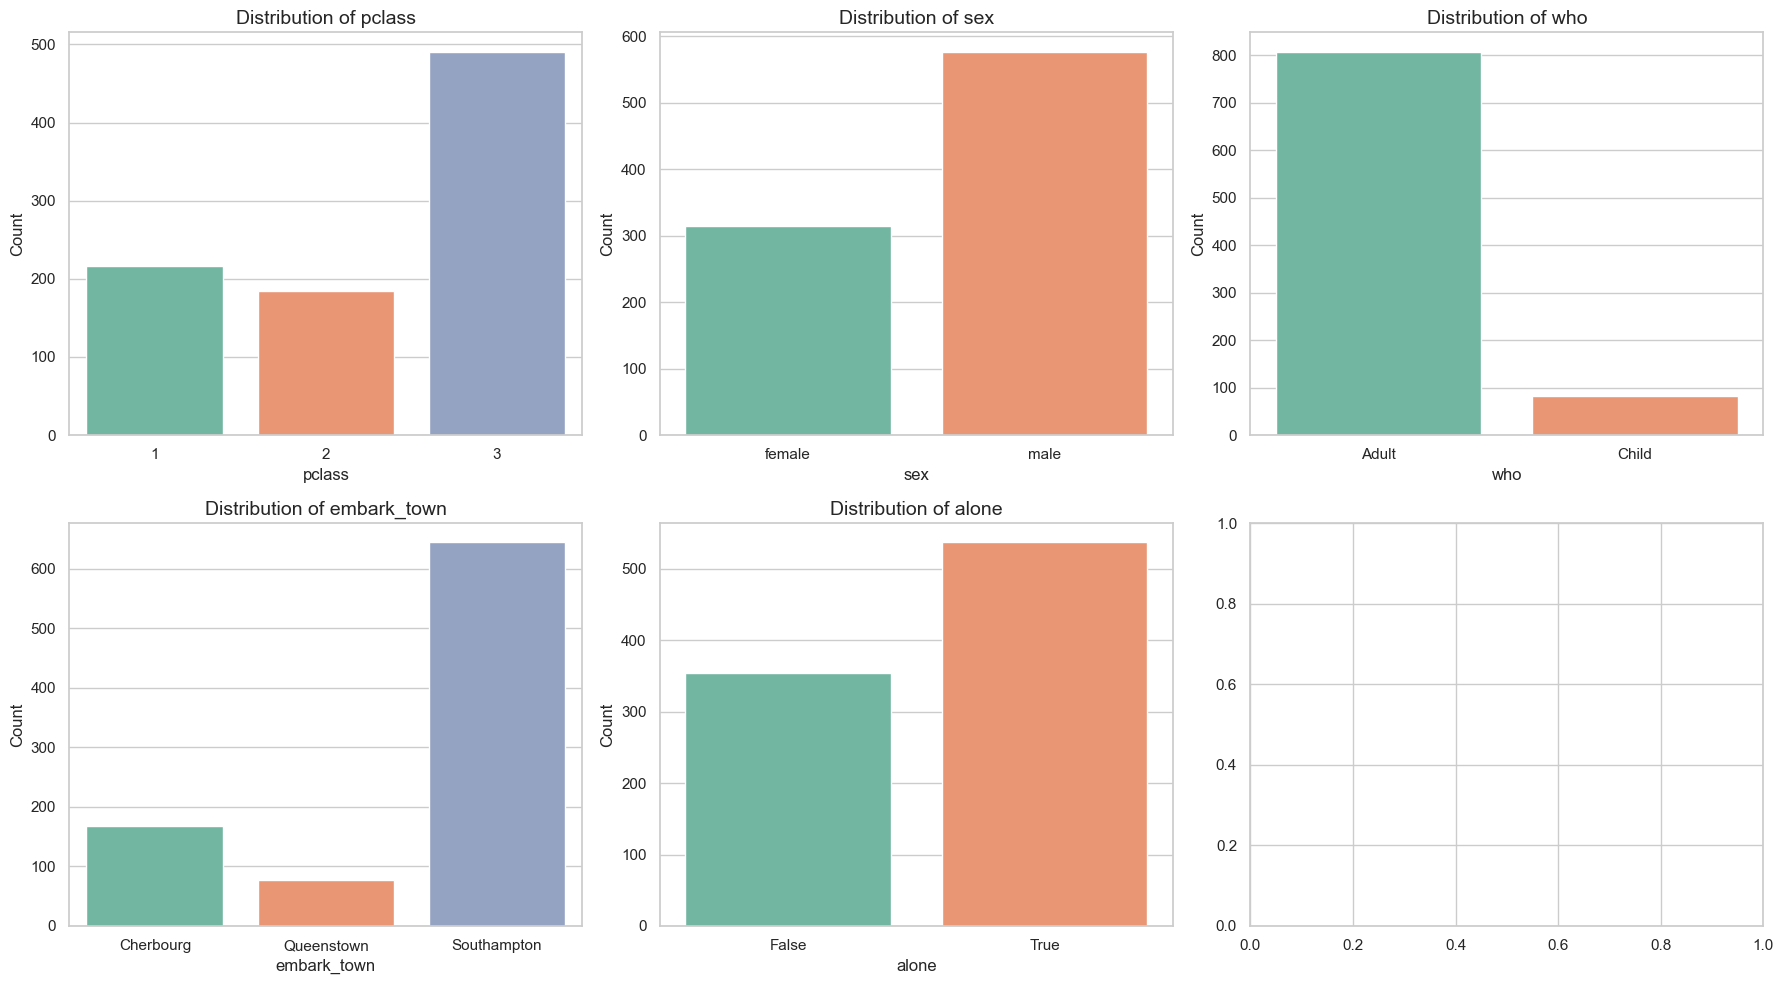

In [142]:
# Set plot style
sns.set(style="whitegrid")

# Plot categorical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Categorical variables bar plots
categorical_vars = ['pclass', 'sex', 'who', 'embark_town', 'alone']
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, data=df, ax=axes[i//3, i%3], palette="Set2")
    axes[i//3, i%3].set_title(f'Distribution of {var}', fontsize=14)
    axes[i//3, i%3].set_ylabel('Count')

plt.tight_layout()
plt.show()

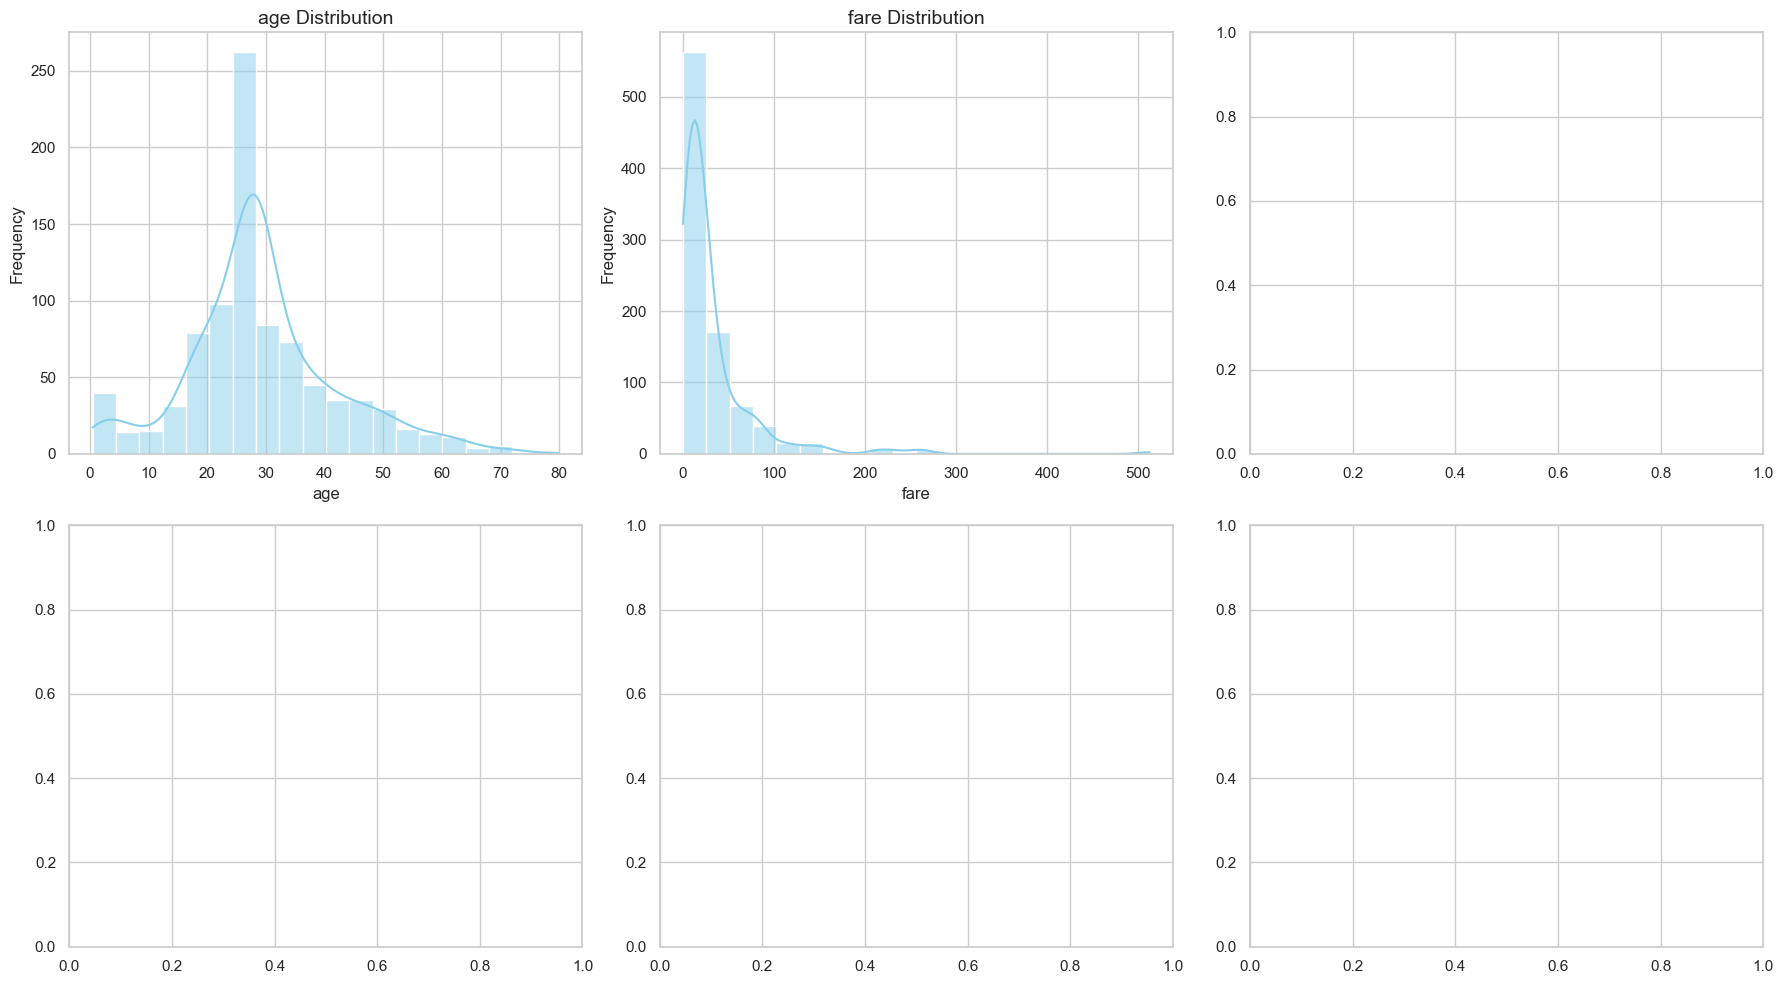

In [143]:
# Histograms and KDE plots for numerical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(numerical_vars):
    sns.histplot(df[var], kde=True, ax=axes[i//3, i%3], color='skyblue', bins=20)
    axes[i//3, i%3].set_title(f'{var} Distribution', fontsize=14)
    axes[i//3, i%3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

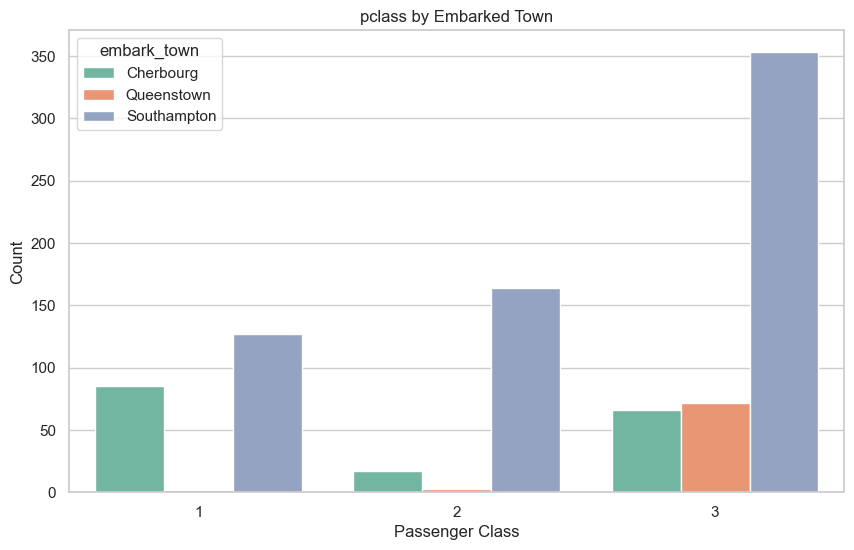

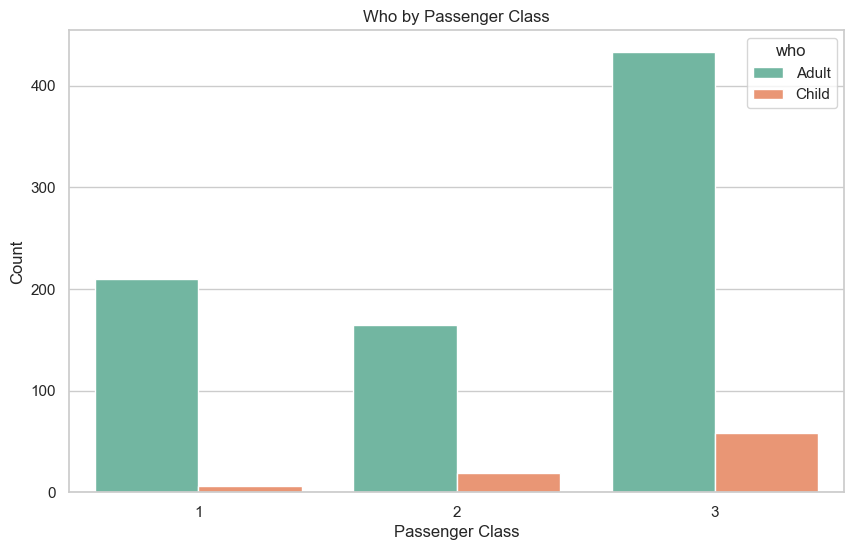

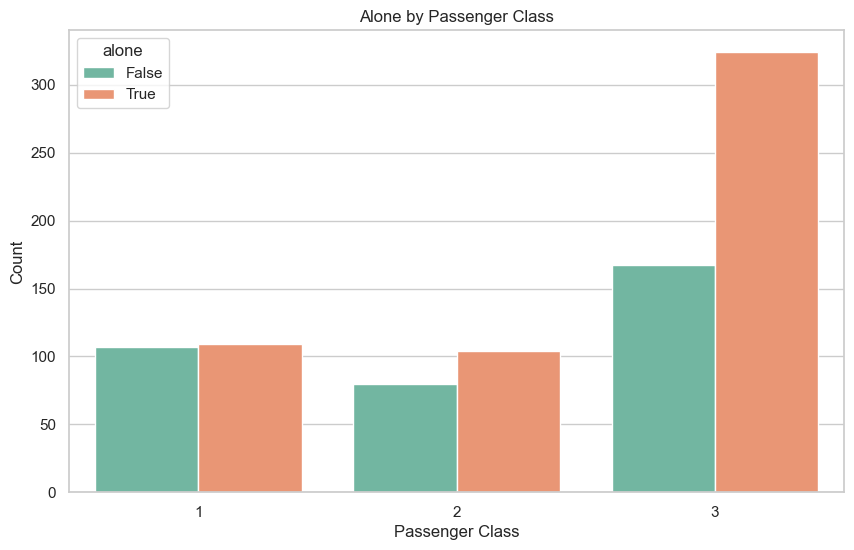

In [144]:
# Plot for 'pclass' vs 'embarked_town'
plt.figure(figsize=(10, 6))
sns.countplot(x='pclass', hue='embark_town', data=df, palette="Set2")
plt.title('pclass by Embarked Town')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()

# Plot for 'who' vs 'pclass'
plt.figure(figsize=(10, 6))
sns.countplot(x='pclass', hue='who', data=df, palette="Set2")
plt.title('Who by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()

# Plot for 'alone' vs 'class' (since 'class' is redundant with 'pclass', we use 'pclass' here)
plt.figure(figsize=(10, 6))
sns.countplot(x='pclass', hue='alone', data=df, palette="Set2")
plt.title('Alone by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2333841046.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




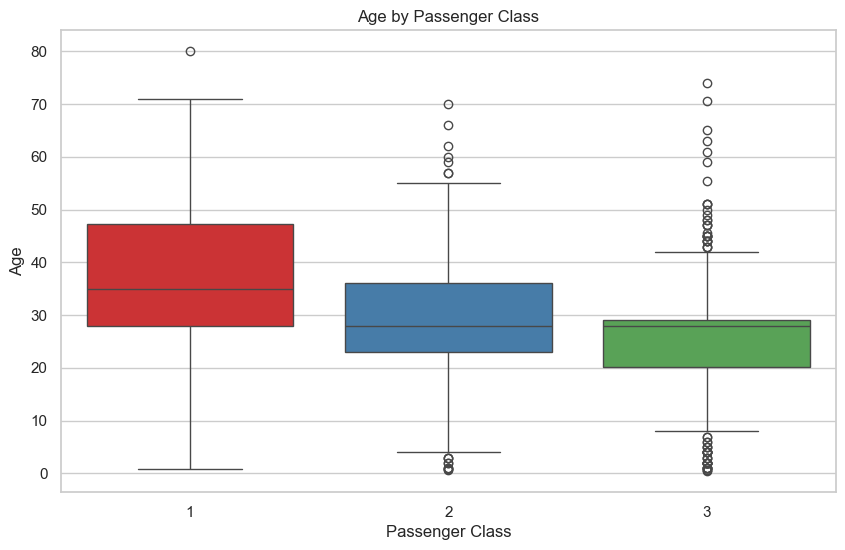

C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\2333841046.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




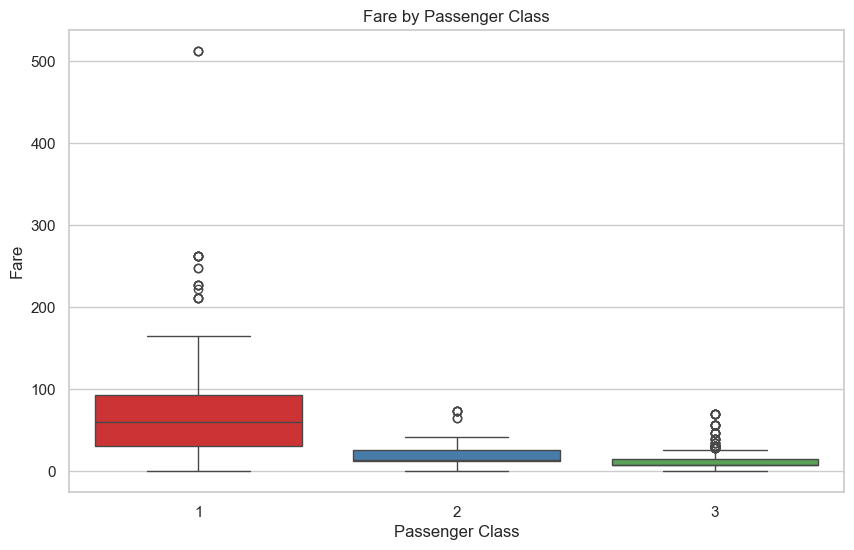

In [121]:
# Plot for 'age' by 'pclass' (distribution of age across pclass)
plt.figure(figsize=(10, 6))
sns.boxplot(x='pclass', y='age', data=df, palette="Set1")
plt.title('Age by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()

# Plot for 'fare' by 'pclass' (distribution of fare across pclass)
plt.figure(figsize=(10, 6))
sns.boxplot(x='pclass', y='fare', data=df, palette="Set1")
plt.title('Fare by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.show()


In [123]:
# From this graph, we can see that:
# - majority of passengers were adult males who travelled in the cheapest class number 3
# - majority of passengers embarked in Southhampton - especially the cheapest tickets. From another side, CHerbough was a embark city for richer passengers who were travelling in class number 1
# - in higher classes we could see people who are more likely to travel with somebody - not alone

## # Train-test split


In [127]:
df['survived'].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [128]:
# Our target variable is not balanced. We have a lot of zeros. We will need to stratify it, in order to keep the same proportion of each class inside this variable in both test and trainign subsets

C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\478101139.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\478101139.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\478101139.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grzes\AppData\Local\Temp\ipykernel_22320\478101139.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect

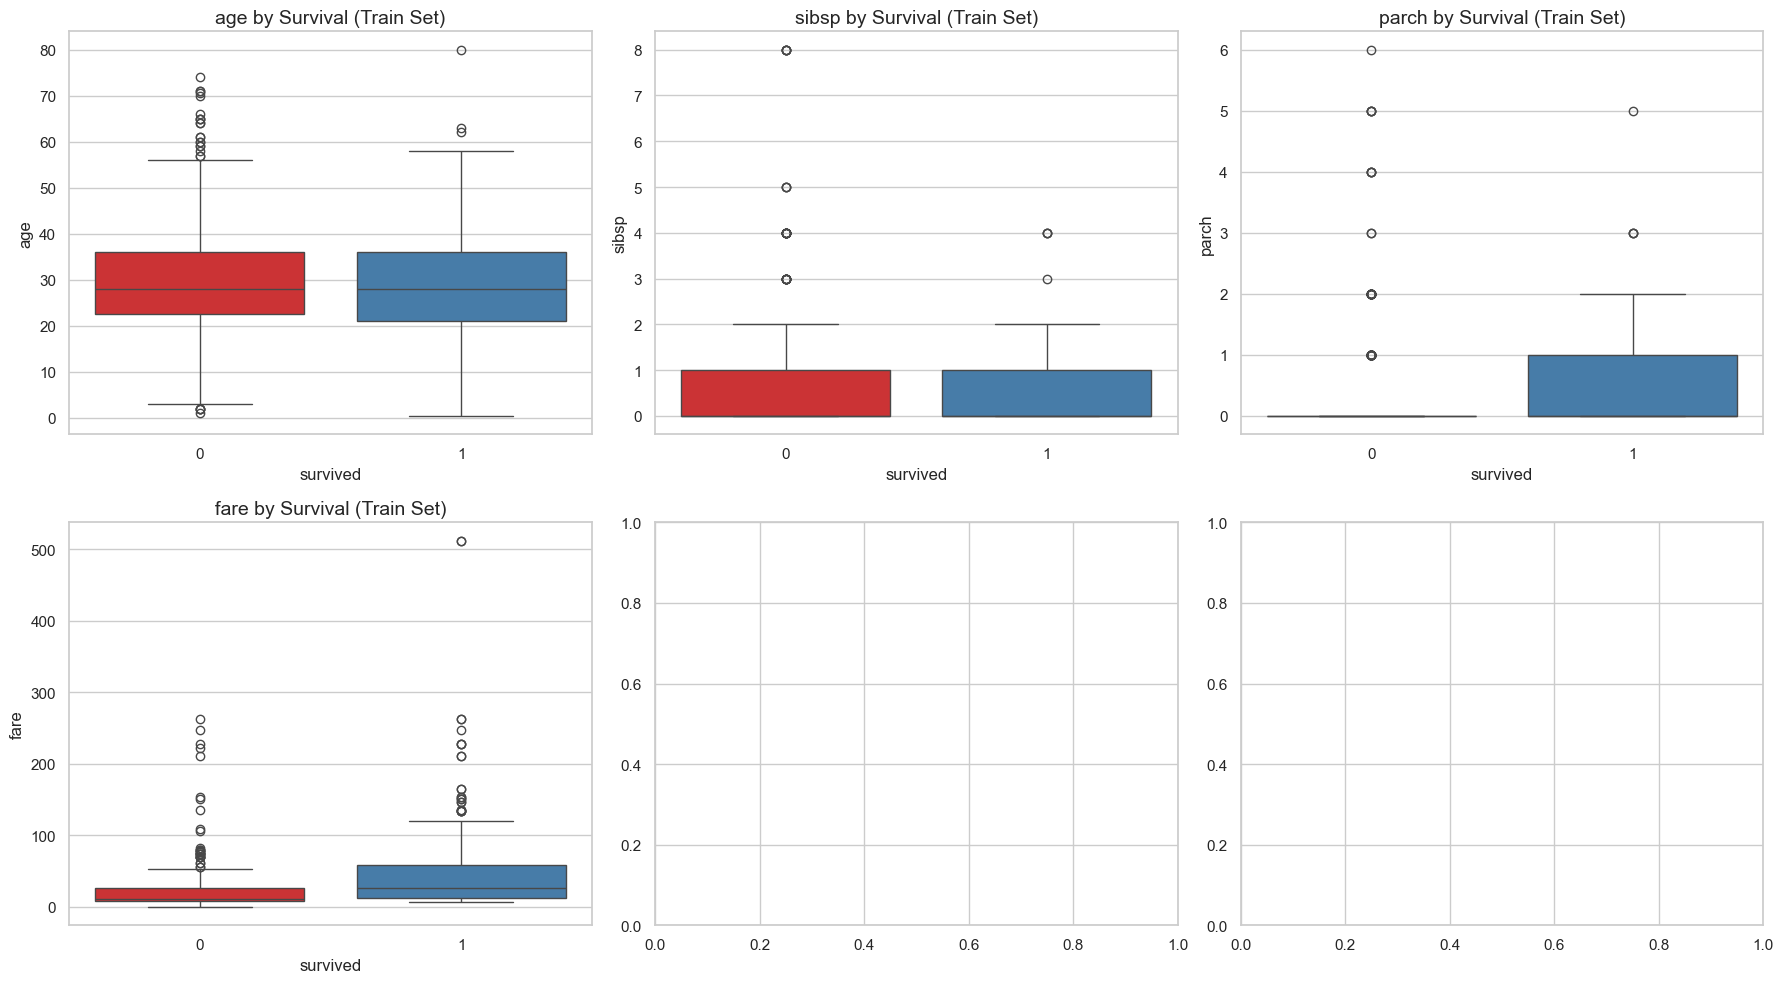

In [145]:
# Boxplots for numerical variables by 'survived' in the training set
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

numerical_vars = ['age', 'sibsp', 'parch', 'fare']
for i, var in enumerate(numerical_vars):
    sns.boxplot(x='survived', y=var, data=train_df, ax=axes[i//3, i%3], palette="Set1")
    axes[i//3, i%3].set_title(f'{var} by Survival (Train Set)', fontsize=14)
    axes[i//3, i%3].set_ylabel(var)

plt.tight_layout()
plt.show()


In [129]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['survived'])

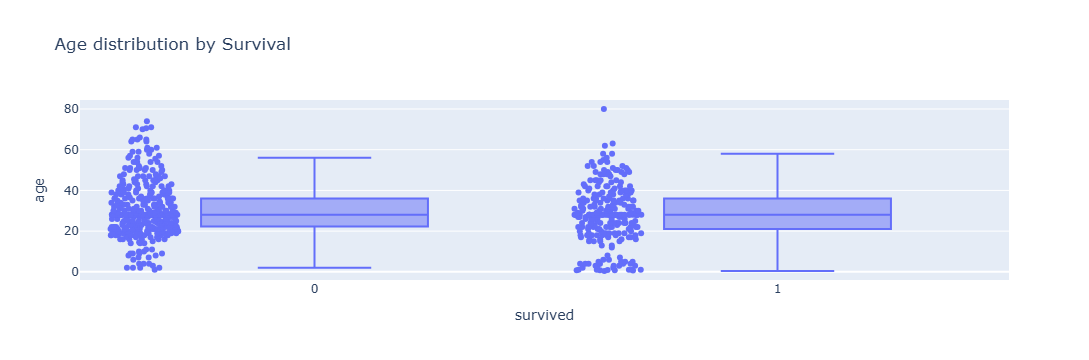

Chi2 test (Sex vs Survived): p = 0.0000
Chi2 test (Person Type vs Survived): p = 0.0005
ANOVA (Age vs Survived): p = 0.0571


In [173]:
# Boxplot: Age vs Survived
fig = px.box(train_df, x='survived', y='age', points='all', title='Age distribution by Survival')
fig.show()

# Chi-square test: Sex vs Survived
contingency_sex = pd.crosstab(train_df['sex'], train_df['survived'])
chi2, p, _, _ = chi2_contingency(contingency_sex)
print(f"Chi2 test (Sex vs Survived): p = {p:.4f}")

# Chi-square test: who vs Survived
contingency_person = pd.crosstab(train_df['who'], train_df['survived'])
chi2, p, _, _ = chi2_contingency(contingency_person)
print(f"Chi2 test (Person Type vs Survived): p = {p:.4f}")

# ANOVA: Age vs Survived
grouped_age = [group['age'].dropna() for _, group in train_df.groupby('survived')]
f_stat, p_val = f_oneway(*grouped_age)
print(f"ANOVA (Age vs Survived): p = {p_val:.4f}")


## Feature encoding

In [138]:
# Categorical variables
# One-Hot Encoding is common for nominal categorical variables (like sex, who, embark_town).

# Label Encoding or Ordinal Encoding is better for ordinal variables (like pclass which has an order).

In [146]:
# One-Hot Encoding for categorical variables
train_df_encoded = pd.get_dummies(train_df, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, drop_first=True)

# Ensure that train and test have the same columns
train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1)

In [147]:
from sklearn.preprocessing import LabelEncoder

# Label encode the 'pclass' column (since it's ordinal)
label_encoder = LabelEncoder()
train_df_encoded['pclass'] = label_encoder.fit_transform(train_df['pclass'])
test_df_encoded['pclass'] = label_encoder.transform(test_df['pclass'])

In [148]:
# Numerical variables
from sklearn.preprocessing import StandardScaler

# Select numerical variables
numerical_vars = ['age', 'fare']

# Standardize the numerical features
scaler = StandardScaler()
train_df_encoded[numerical_vars] = scaler.fit_transform(train_df_encoded[numerical_vars])
test_df_encoded[numerical_vars] = scaler.transform(test_df_encoded[numerical_vars])

## Logistic regression

In [156]:
# Let's perform logistic regression on the trained data subset

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split into X (features) and y (target variable)
X_train = train_df_encoded.drop(columns='survived')  # drop target column
y_train = train_df_encoded['survived']

X_test = test_df_encoded.drop(columns='survived')
y_test = test_df_encoded['survived']

# Initialize and train Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Model evaluation

In [157]:
# Let's let the model to make predictions on the test data subset

In [151]:
from sklearn.metrics import accuracy_score

# Predict the test set results
y_pred = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.24%


In [162]:
df['survived'].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [158]:
# Out of all passengers in the test set, 83.24% were correctly classified as either survived (1) or did not survive (0).

In [163]:
# Around 60% passengers in total died, so predicitng everything as 'died' would give us accurancy equal to around 60%. So our model outperforms this
# number by around 20 percentage points

In [152]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report (Precision, Recall, F1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[101   9]
 [ 21  48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



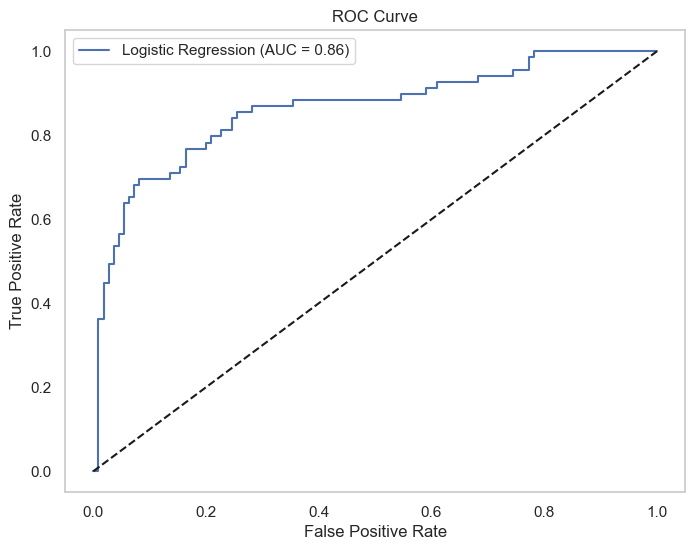

In [164]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = logreg.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [174]:
# AUC equal to 86% confirms that the model predicts better than just random guessing

## Cross-validation

In [168]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

# Setup stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize your model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Perform cross-validation on the training set
f1_scores = cross_val_score(logreg, X_train_encoded, y_train, cv=cv, scoring='f1')

# Output results
print(f"Cross-validated F1 scores: {f1_scores}")
print(f"Mean F1 score: {np.mean(f1_scores):.4f}")


Cross-validated F1 scores: [0.74576271 0.7047619  0.78504673 0.71559633 0.73076923]
Mean F1 score: 0.7364


In [170]:
# As our initial model had a higher F1 score than the average one from croos-validation, wE can say that our initial model probably had an easier job
# in the initial test subset. 
# Now, let's tune the parameters

In [169]:
# Made with AI help
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],               # regularization strength
    'penalty': ['l2'],                          # L1 is only supported with solvers like 'liblinear'
    'solver': ['lbfgs'],                        # supports L2 and multiclass
    'max_iter': [1000]                          # just to ensure convergence
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit to training data
grid_search.fit(X_train_encoded, y_train)

# Best model + score
print("Best parameters:", grid_search.best_params_)
print(f"Best F1 score (CV): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score (CV): 0.7480


In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Best parameters found from GridSearchCV
best_params = grid_search.best_params_

# Initialize the model with the best parameters
final_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=best_params['max_iter'],
    random_state=42
)

# Train the model on the entire training data
final_model.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred_test = final_model.predict(X_test_encoded)

# Evaluate the model on the test set
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Calculate accuracy
accuracy = final_model.score(X_test_encoded, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179

Confusion Matrix:
[[93 17]
 [23 46]]
Test Accuracy: 77.65%


In [175]:
# The final model used to predict passenger survival on the Titanic is a Logistic Regression model with hyperparameters tuned through GridSearchCV. 
# The model was trained using the best combination of hyperparameters, including C=100, penalty='l2', and solver='lbfgs', after performing cross-validation to ensure a reliable performance estimate.

# Upon evaluation, the model achieved a test accuracy of 77.65% and performed reasonably well with an F1 score of 0.70 for the minority class (survived). 
# While the model is better at predicting the non-survived passengers, it still demonstrates a good balance between precision and recall. 